In [5]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from proglearn.forest import UncertaintyForest

from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_context("paper", font_scale=1.5)

In [7]:
helper = lambda x, alpha: 1 / (1 + np.exp(-alpha*(x-1/2)))
analytical_prob = lambda X, alpha: np.asarray([helper(x[0], alpha) * helper(x[1], alpha) for x in X])

def sample_data(n, d, seed=None, alpha=12):
    np.random.seed(seed)
    X = np.random.uniform(0, 1, (n, d))
    
    y_probs = analytical_prob(X, alpha)
    y = np.random.binomial(1, y_probs, size=y_probs.shape)
    
    return X, y, y_probs

In [8]:
def hellinger_explicit(p, q):
    """Hellinger distance between two discrete distributions.
       Same as original version but without list comprehension
    """
    # If one dimensional, assume are the probs of class 1
    if p.ndim == 1:
        p = np.vstack([np.ones(p.shape[0]) - p, p]).T
    if q.ndim == 1:
        q = np.vstack([np.ones(q.shape[0]) - q, q]).T
    return np.mean(np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2, axis = 1)) / np.sqrt(2))

## Original UF (check that nothing has changed)

2
4
8
12
20
40
100


IRF     SigRF        UF        RF
d                                          
2    0.067059  0.091835  0.045213  0.083696
4    0.065240  0.085219  0.053642  0.062693
8    0.056210  0.073318  0.048796  0.058202
12   0.059589  0.075508  0.052506  0.065898
20   0.059118  0.076810  0.053519  0.080397
40   0.070797  0.083455  0.059103  0.104071
100  0.074737  0.082761  0.064331  0.139546

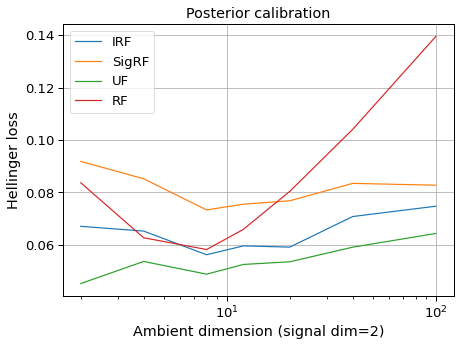

In [12]:
n_estimators = 500
n_jobs = 5
cv = 5

clfs = [
    ('IRF', CalibratedClassifierCV(
            base_estimator=RandomForestClassifier(n_estimators=n_estimators//cv, n_jobs=n_jobs),
            method="isotonic",
            cv=cv,
        )),
    ('SigRF', CalibratedClassifierCV(
            base_estimator=RandomForestClassifier(n_estimators=n_estimators//cv, n_jobs=n_jobs),
            method="sigmoid",
            cv=cv,
        )),
    ('UF', UncertaintyForest(
            n_estimators=n_estimators, tree_construction_proportion=0.5, kappa=1,
            max_samples=1.0, poisson_sampler=False, max_features=None, n_jobs=n_jobs
        )),
    ('RF', RandomForestClassifier(n_estimators=n_estimators, n_jobs=n_jobs))
]

results_dict_half = defaultdict(list)
dims = [2, 4, 8]
dims += [12, 20]
dims += [40, 100]
results_dict_half['d'] = dims

for d in dims:
    print(d)
    X_train, y_train, y_probs_train = sample_data(5000, d, seed=d)
    X_test, y_test, y_probs_test = sample_data(10000, d, seed=d+1)
    results_dict_half['y_test'].append(y_test)
    results_dict_half['y_probs_test'].append(y_probs_test)
    for name, clf in clfs:
        clf.fit(X_train, y_train)
        y_probs_test_hat = clf.predict_proba(X_test)[:, 1] # class 1 probs
        results_dict_half[name].append(y_probs_test_hat)
        
cols = ['d'] + [clf for clf, _ in clfs]

data = [results_dict_half['d']]
for clf, _ in clfs:
    scores = [
        hellinger_explicit(results_dict_half['y_probs_test'][i], y_proba_hat)
        for i, y_proba_hat in enumerate(results_dict_half[clf])
    ]
    data.append(scores)
    
df = pd.DataFrame(np.asarray(data).T, columns=cols).astype({'d': int}).set_index('d')

display(df)

df.plot(figsize=(7, 5), grid=True)
plt.xlabel('Ambient dimension (signal dim=2)')
plt.ylabel('Hellinger loss')
plt.title('Posterior calibration')
plt.xticks(np.linspace(2, 20, 7))
plt.xscale('log')
plt.show()

## Effect of Half samples

2
4
8
12
20
40


IRF     SigRF        UF        RF
d                                         
2   0.090712  0.113741  0.048117  0.122008
4   0.083337  0.102465  0.053705  0.087541
8   0.060654  0.078709  0.055134  0.061407
12  0.064757  0.079425  0.056472  0.065058
20  0.062847  0.078779  0.060334  0.075634
40  0.070814  0.083565  0.064571  0.092339

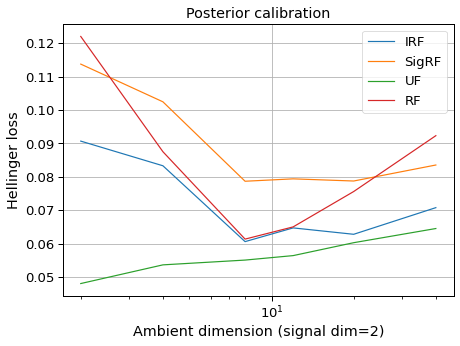

In [20]:
n_estimators = 500
n_jobs = 5
cv = 5

clfs = [
    ('IRF', CalibratedClassifierCV(
            base_estimator=RandomForestClassifier(
                n_estimators=n_estimators//cv,
                max_samples=0.5,
                bootstrap=False,
                n_jobs=n_jobs),
            method="isotonic",
            cv=cv,
        )),
    ('SigRF', CalibratedClassifierCV(
            base_estimator=RandomForestClassifier(
                n_estimators=n_estimators//cv,
                max_samples=0.5,
                bootstrap=False,
                n_jobs=n_jobs),
            method="sigmoid",
            cv=cv,
        )),
    ('UF', UncertaintyForest(
            n_estimators=n_estimators, tree_construction_proportion=0.5, kappa=1,
            max_samples=0.5, poisson_sampler=False, max_features=None, n_jobs=n_jobs
        )),
    ('RF', RandomForestClassifier(
        n_estimators=n_estimators,
        max_samples=0.5,
        bootstrap=False,
        n_jobs=n_jobs))
]

results_dict_half = defaultdict(list)
dims = [2, 4, 8, 12, 20, 40]
results_dict_half['d'] = dims

for d in dims:
    print(d)
    X_train, y_train, y_probs_train = sample_data(5000, d, seed=d)
    X_test, y_test, y_probs_test = sample_data(10000, d, seed=d+1)
    results_dict_half['y_test'].append(y_test)
    results_dict_half['y_probs_test'].append(y_probs_test)
    for name, clf in clfs:
        clf.fit(X_train, y_train)
        y_probs_test_hat = clf.predict_proba(X_test)[:, 1] # class 1 probs
        results_dict_half[name].append(y_probs_test_hat)
        
cols = ['d'] + [clf for clf, _ in clfs]

data = [results_dict_half['d']]
for clf, _ in clfs:
    scores = [
        hellinger_explicit(results_dict_half['y_probs_test'][i], y_proba_hat)
        for i, y_proba_hat in enumerate(results_dict_half[clf])
    ]
    data.append(scores)
    
df = pd.DataFrame(np.asarray(data).T, columns=cols).astype({'d': int}).set_index('d')

display(df)

df.plot(figsize=(7, 5), grid=True)
plt.xlabel('Ambient dimension (signal dim=2)')
plt.ylabel('Hellinger loss')
plt.title('Posterior calibration')
plt.xticks(np.linspace(2, 20, 7))
plt.xscale('log')
plt.show()

2
4
8
12
20
40


IRF     SigRF        UF        RF
d                                         
2   0.055560  0.081049  0.048117  0.066711
4   0.059180  0.078556  0.053705  0.054867
8   0.053709  0.072693  0.055134  0.060471
12  0.059259  0.075050  0.056472  0.068535
20  0.060386  0.076637  0.060334  0.087223
40  0.070886  0.084145  0.064571  0.114660

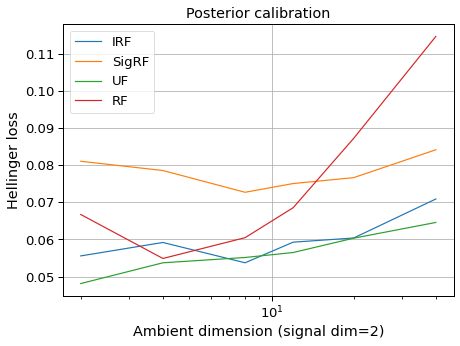

In [21]:
n_estimators = 500
n_jobs = 5
cv = 5

clfs = [
    ('IRF', CalibratedClassifierCV(
            base_estimator=RandomForestClassifier(
                n_estimators=n_estimators//cv,
                max_samples=0.5,
                n_jobs=n_jobs),
            method="isotonic",
            cv=cv,
        )),
    ('SigRF', CalibratedClassifierCV(
            base_estimator=RandomForestClassifier(
                n_estimators=n_estimators//cv,
                max_samples=0.5,
                n_jobs=n_jobs),
            method="sigmoid",
            cv=cv,
        )),
    ('UF', UncertaintyForest(
            n_estimators=n_estimators, tree_construction_proportion=0.5, kappa=1,
            max_samples=0.5, poisson_sampler=False, max_features=None, n_jobs=n_jobs
        )),
    ('RF', RandomForestClassifier(
        n_estimators=n_estimators,
        max_samples=0.5,
        n_jobs=n_jobs))
]

results_dict_half = defaultdict(list)
dims = [2, 4, 8, 12, 20, 40]
results_dict_half['d'] = dims

for d in dims:
    print(d)
    X_train, y_train, y_probs_train = sample_data(5000, d, seed=d)
    X_test, y_test, y_probs_test = sample_data(10000, d, seed=d+1)
    results_dict_half['y_test'].append(y_test)
    results_dict_half['y_probs_test'].append(y_probs_test)
    for name, clf in clfs:
        clf.fit(X_train, y_train)
        y_probs_test_hat = clf.predict_proba(X_test)[:, 1] # class 1 probs
        results_dict_half[name].append(y_probs_test_hat)
        
cols = ['d'] + [clf for clf, _ in clfs]

data = [results_dict_half['d']]
for clf, _ in clfs:
    scores = [
        hellinger_explicit(results_dict_half['y_probs_test'][i], y_proba_hat)
        for i, y_proba_hat in enumerate(results_dict_half[clf])
    ]
    data.append(scores)
    
df = pd.DataFrame(np.asarray(data).T, columns=cols).astype({'d': int}).set_index('d')

display(df)

df.plot(figsize=(7, 5), grid=True)
plt.xlabel('Ambient dimension (signal dim=2)')
plt.ylabel('Hellinger loss')
plt.title('Posterior calibration')
plt.xticks(np.linspace(2, 20, 7))
plt.xscale('log')
plt.show()

## Effect of max_features (no poisson)

2
4
8
12
20
40


IRF     SigRF        UF        RF
d                                         
2   0.067059  0.091835  0.044157  0.083696
4   0.065240  0.085219  0.059482  0.062693
8   0.056210  0.073318  0.076614  0.058202
12  0.059589  0.075508  0.078110  0.065898
20  0.059118  0.076810  0.096887  0.080397
40  0.070797  0.083455  0.114972  0.104071

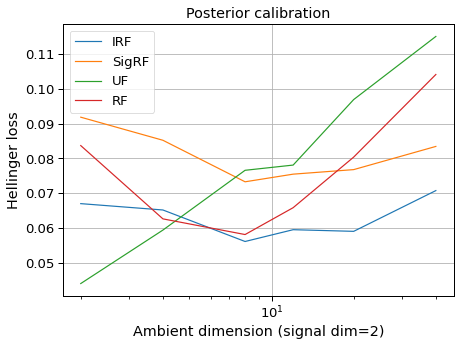

In [14]:
n_estimators = 500
n_jobs = 5
cv = 5

clfs = [
    ('IRF', CalibratedClassifierCV(
            base_estimator=RandomForestClassifier(n_estimators=n_estimators//cv, n_jobs=n_jobs),
            method="isotonic",
            cv=cv,
        )),
    ('SigRF', CalibratedClassifierCV(
            base_estimator=RandomForestClassifier(n_estimators=n_estimators//cv, n_jobs=n_jobs),
            method="sigmoid",
            cv=cv,
        )),
    ('UF', UncertaintyForest(
            n_estimators=n_estimators, tree_construction_proportion=0.5, kappa=1,
            max_samples=1.0, poisson_sampler=False, max_features='sqrt', n_jobs=n_jobs
        )),
    ('RF', RandomForestClassifier(n_estimators=n_estimators, n_jobs=n_jobs))
]

results_dict_half = defaultdict(list)
dims = [2, 4, 8, 12, 20, 40]
results_dict_half['d'] = dims

for d in dims:
    print(d)
    X_train, y_train, y_probs_train = sample_data(5000, d, seed=d)
    X_test, y_test, y_probs_test = sample_data(10000, d, seed=d+1)
    results_dict_half['y_test'].append(y_test)
    results_dict_half['y_probs_test'].append(y_probs_test)
    for name, clf in clfs:
        clf.fit(X_train, y_train)
        y_probs_test_hat = clf.predict_proba(X_test)[:, 1] # class 1 probs
        results_dict_half[name].append(y_probs_test_hat)
        
cols = ['d'] + [clf for clf, _ in clfs]

data = [results_dict_half['d']]
for clf, _ in clfs:
    scores = [
        hellinger_explicit(results_dict_half['y_probs_test'][i], y_proba_hat)
        for i, y_proba_hat in enumerate(results_dict_half[clf])
    ]
    data.append(scores)
    
df = pd.DataFrame(np.asarray(data).T, columns=cols).astype({'d': int}).set_index('d')

display(df)

df.plot(figsize=(7, 5), grid=True)
plt.xlabel('Ambient dimension (signal dim=2)')
plt.ylabel('Hellinger loss')
plt.title('Posterior calibration')
plt.xticks(np.linspace(2, 20, 7))
plt.xscale('log')
plt.show()

## All forests max_features=n_features

2
4
8
12
20
40


IRF     SigRF        UF        RF
d                                         
2   0.066783  0.095964  0.045213  0.094769
4   0.069804  0.088906  0.053642  0.073413
8   0.059776  0.075976  0.048796  0.066525
12  0.063839  0.077463  0.052506  0.068054
20  0.063718  0.077460  0.053519  0.069973
40  0.069071  0.079963  0.059103  0.068483

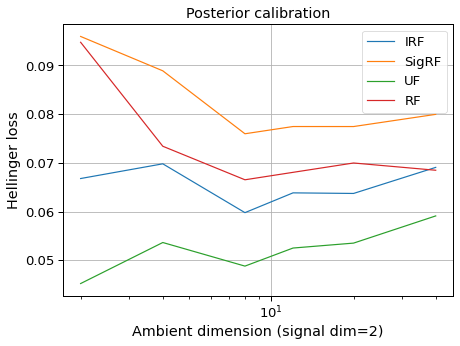

In [17]:
n_estimators = 500
n_jobs = 5
cv = 5

clfs = [
    ('IRF', CalibratedClassifierCV(
            base_estimator=RandomForestClassifier(
                n_estimators=n_estimators//cv,
                max_features=1.0,
                n_jobs=n_jobs),
            method="isotonic",
            cv=cv,
        )),
    ('SigRF', CalibratedClassifierCV(
            base_estimator=RandomForestClassifier(
                n_estimators=n_estimators//cv,
                max_features=1.0,
                n_jobs=n_jobs),
            method="sigmoid",
            cv=cv,
        )),
    ('UF', UncertaintyForest(
            n_estimators=n_estimators, tree_construction_proportion=0.5, kappa=1,
            max_samples=1.0, poisson_sampler=False, max_features=1.0, n_jobs=n_jobs
        )),
    ('RF', RandomForestClassifier(
        n_estimators=n_estimators,
        max_features=1.0,
        n_jobs=n_jobs))
]

results_dict_half = defaultdict(list)
dims = [2, 4, 8, 12, 20, 40]
results_dict_half['d'] = dims

for d in dims:
    print(d)
    X_train, y_train, y_probs_train = sample_data(5000, d, seed=d)
    X_test, y_test, y_probs_test = sample_data(10000, d, seed=d+1)
    results_dict_half['y_test'].append(y_test)
    results_dict_half['y_probs_test'].append(y_probs_test)
    for name, clf in clfs:
        clf.fit(X_train, y_train)
        y_probs_test_hat = clf.predict_proba(X_test)[:, 1] # class 1 probs
        results_dict_half[name].append(y_probs_test_hat)
        
cols = ['d'] + [clf for clf, _ in clfs]

data = [results_dict_half['d']]
for clf, _ in clfs:
    scores = [
        hellinger_explicit(results_dict_half['y_probs_test'][i], y_proba_hat)
        for i, y_proba_hat in enumerate(results_dict_half[clf])
    ]
    data.append(scores)
    
df = pd.DataFrame(np.asarray(data).T, columns=cols).astype({'d': int}).set_index('d')

display(df)

df.plot(figsize=(7, 5), grid=True)
plt.xlabel('Ambient dimension (signal dim=2)')
plt.ylabel('Hellinger loss')
plt.title('Posterior calibration')
plt.xticks(np.linspace(2, 20, 7))
plt.xscale('log')
plt.show()

## Full GRF parameters

In [ ]:
n_estimators = 500
n_jobs = 5
cv = 5

clfs = [
    ('IRF', CalibratedClassifierCV(
            base_estimator=RandomForestClassifier(n_estimators=n_estimators//cv, n_jobs=n_jobs),
            method="isotonic",
            cv=cv,
        )),
    ('SigRF', CalibratedClassifierCV(
            base_estimator=RandomForestClassifier(n_estimators=n_estimators//cv, n_jobs=n_jobs),
            method="sigmoid",
            cv=cv,
        )),
    ('UF', UncertaintyForest(
            n_estimators=n_estimators, tree_construction_proportion=0.5, kappa=1,
            max_samples=0.5, poisson_sampler=True, max_features='auto', n_jobs=n_jobs
        )),
    ('RF', RandomForestClassifier(n_estimators=n_estimators, n_jobs=n_jobs))
]

In [9]:
results_dict = defaultdict(list)
dims = [2, 4, 6, 8]
dims += [12, 16, 20]
dims += [40, 60, 100]
results_dict['d'] = dims

for d in dims:
    print(d)
    X_train, y_train, y_probs_train = sample_data(5000, d, seed=d)
    X_test, y_test, y_probs_test = sample_data(10000, d, seed=d+1)
    results_dict['y_test'].append(y_test)
    results_dict['y_probs_test'].append(y_probs_test)
    for name, clf in clfs:
        clf.fit(X_train, y_train)
        y_probs_test_hat = clf.predict_proba(X_test)[:, 1] # class 1 probs
        results_dict[name].append(y_probs_test_hat)

2
4
6
8
12
16
20
40
60
100


In [10]:
cols = ['d'] + [clf for clf, _ in clfs]

data = [results_dict['d']]
for clf, _ in clfs:
    scores = [
        hellinger_explicit(results_dict['y_probs_test'][i], y_proba_hat)
        for i, y_proba_hat in enumerate(results_dict[clf])
    ]
    data.append(scores)
    
df = pd.DataFrame(np.asarray(data).T, columns=cols).astype({'d': int}).set_index('d')

IRF     SigRF        UF        RF
d                                          
2    0.067059  0.091835  0.043507  0.083847
4    0.065240  0.085219  0.066913  0.062879
6    0.056841  0.076332  0.076081  0.054883
8    0.056210  0.073318  0.091115  0.058679
12   0.059589  0.075508  0.097835  0.064277
16   0.059036  0.077336  0.100336  0.070509
20   0.059118  0.076810  0.111723  0.080877
40   0.070797  0.083455  0.128576  0.103186
60   0.068582  0.081110  0.145915  0.123526
100  0.074737  0.082761  0.155278  0.142131

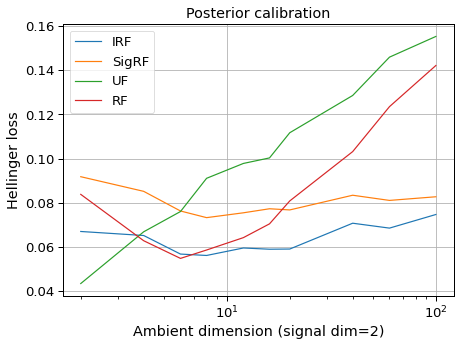

In [11]:
display(df)

df.plot(figsize=(7, 5), grid=True)
plt.xlabel('Ambient dimension (signal dim=2)')
plt.ylabel('Hellinger loss')
plt.title('Posterior calibration')
plt.xticks(np.linspace(2, 20, 7))
plt.xscale('log')
plt.show()

## Prior to parameter update

In [16]:
df

IRF     SigRF        UF        RF
d                                          
2    0.067059  0.091835  0.045216  0.083696
4    0.065240  0.085219  0.053642  0.062693
6    0.056841  0.076332  0.050278  0.055190
8    0.056210  0.073318  0.048796  0.058202
12   0.059589  0.075508  0.052506  0.065898
16   0.059036  0.077336  0.055986  0.072044
20   0.059118  0.076810  0.053519  0.080397
40   0.070797  0.083455  0.059103  0.104071
60   0.068582  0.081110  0.056793  0.128673
100  0.074737  0.082761  0.064331  0.139546

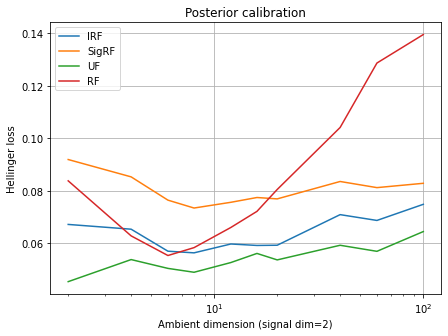

In [17]:
df.plot(figsize=(7, 5), grid=True)
plt.xlabel('Ambient dimension (signal dim=2)')
plt.ylabel('Hellinger loss')
plt.title('Posterior calibration')
plt.xticks(np.linspace(2, 20, 7))
plt.xscale('log')
plt.show()

In [140]:
def sample_grid(resolution, d, alpha=12, clfs=None, n_reps=100):
    x_min, x_max = 0, 1
    xx1, xx2 = np.meshgrid(
        np.linspace(x_min, x_max, resolution),
        np.linspace(x_min, x_max, resolution))
    X = np.c_[xx1.ravel(), xx2.ravel()]

    y_probs = analytical_prob(X, alpha)
    if clfs is None:
        return X, y_probs

    y_predicted = np.zeros((len(clfs), X.shape[0], 2))
    for _ in range(n_reps):
        noise_dims = np.random.uniform(0, 1, (X.shape[0], d-X.shape[1]))
        for i, clf in enumerate(trained_clfs):
            y_predicted[i] += clf.predict_proba(np.hstack((X, noise_dims)))

    y_predicted = np.asarray(y_predicted) / n_reps
    
    return X, y_probs, y_predicted
    
    
def posterior_heatmap(clfs, names, resolution, d, alpha, n_reps, savedir=None):
    cmap = 'Reds'
    vmin = 0
    vmax = 1
    
    X, y_true, y_predicted_list = sample_grid(
        resolution, d, alpha, clfs, n_reps)
    
    fig, axes = plt.subplots(1, 5, figsize=(18, 3))
    for i, ax in enumerate(axes):
        if i == 0:
            pts = ax.scatter(X[:, 0], X[:, 1], c=y_true, cmap=cmap, vmin=vmin, vmax=vmax)
            ax.set_xlabel(f'True posteriors')
        else:
            pts = ax.scatter(X[:, 0], X[:, 1], c=y_predicted_list[i-1][:,1], cmap=cmap, vmin=vmin, vmax=vmax)
            ax.set_xlabel(f'{names[i-1]}')
        ax.set_aspect('equal')
        fig.colorbar(pts, ax=ax)
    plt.tight_layout()
    if savedir is not None:
        plt.savefig(savedir)
    plt.show()

def posterior_diffmap(y_true, y_proba_list):
    cmap = 'RdBu_r'
    vmin = -0.5
    vmax = 0.5

In [103]:
names = [name for name, _ in clfs]
d = 12
X_train, y_train, _ = sample_data(5000, d, seed=d)
trained_clfs = [clf for _, clf in clfs]
for clf in trained_clfs:
    clf.fit(X_train, y_train)

In [120]:
x_min, x_max = 0, 1
resolution = 10
xx1, xx2 = np.meshgrid(
    np.linspace(x_min, x_max, resolution),
    np.linspace(x_min, x_max, resolution))
X = np.c_[xx1.ravel(), xx2.ravel()]

y_probs = analytical_prob(X, alpha)

y_predicted = np.zeros((len(clfs), X.shape[0], 2))

In [138]:
cmap = 'Reds'
vmin = 0
vmax = 1
n_reps = 100
resolution = 50

X, y_true, y_predicted_list = sample_grid(
    resolution, d, alpha, trained_clfs, n_reps)

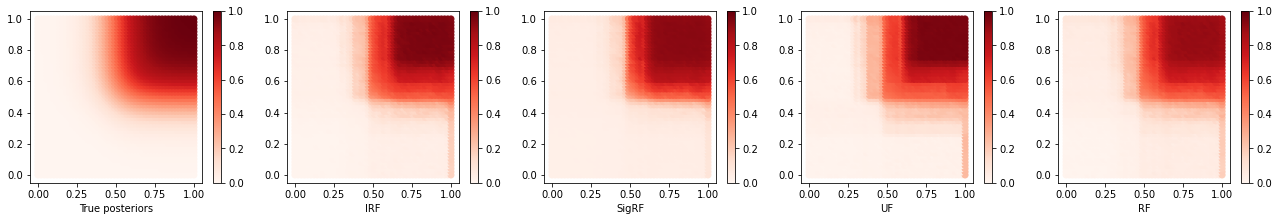

In [143]:
fig, axes = plt.subplots(1, 5, figsize=(18, 3))
for i, ax in enumerate(axes):
    if i == 0:
        pts = ax.scatter(X[:, 0], X[:, 1], c=y_true, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xlabel(f'True posteriors')
    else:
        pts = ax.scatter(X[:, 0], X[:, 1], c=y_predicted_list[i-1][:,1], cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xlabel(f'{names[i-1]}')
    ax.set_aspect('equal')
    fig.colorbar(pts, ax=ax)
# if savedir is not None:
#     plt.savefig(savedir)
plt.tight_layout()
plt.show()

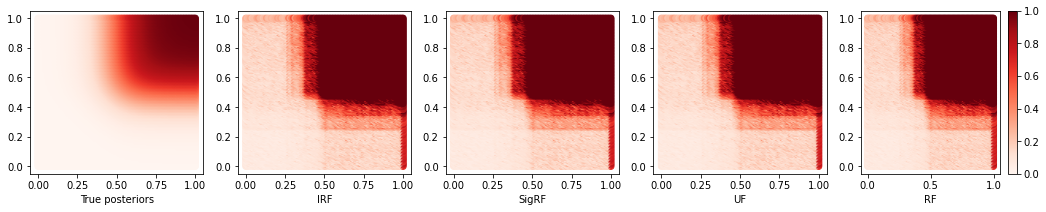

In [75]:
posterior_heatmap(
    trained_clfs,
    names,
    resolution=50, d=d, alpha=12, n_reps=10, savedir=f'./figures/posterior_heatmap_d={d}_alpha=12.pdf'
)

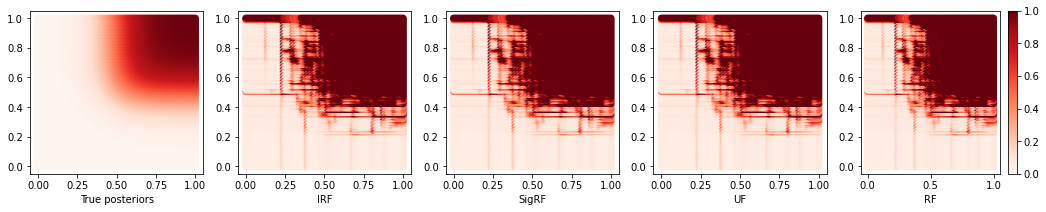

In [72]:
posterior_heatmap(
    trained_clfs,
    names,
    resolution=100, d=d, alpha=12, n_reps=10, savedir='./figures/posterior_heatmap_d=2_alpha=12.pdf'
)

In [90]:
d = 2
d_idx = 0
X_test, _, _ = sample_data(10000, d, seed=d+1)

clf_y_probs_hat = [
    results_dict[clf][d_idx] for clf, _ in clfs
]

y_probs_true = results_dict['y_probs_test'][d_idx]

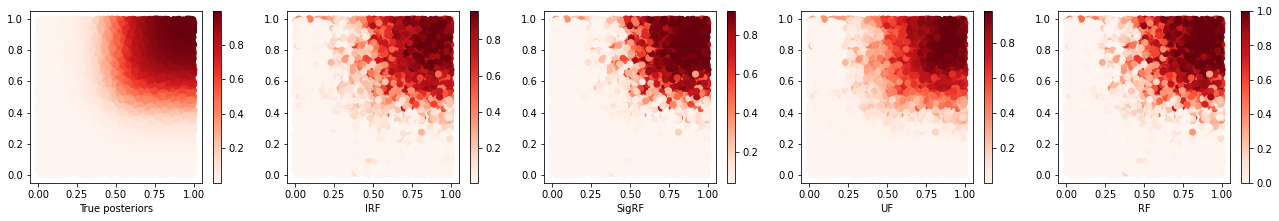

In [91]:
fig, axes = plt.subplots(1, 5, figsize=(18, 3))
for i, ax in enumerate(axes):
    if i == 0:
        pts = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_probs_true, cmap='Reds')
        ax.set_xlabel(f'True posteriors')
    else:
        pts = ax.scatter(X_test[:, 0], X_test[:, 1], c=clf_y_probs_hat[i-1], cmap='Reds')
        ax.set_xlabel(f'{clfs[i-1][0]}')
    ax.set_aspect('equal')
    fig.colorbar(pts, ax=ax)
plt.tight_layout()
plt.show()

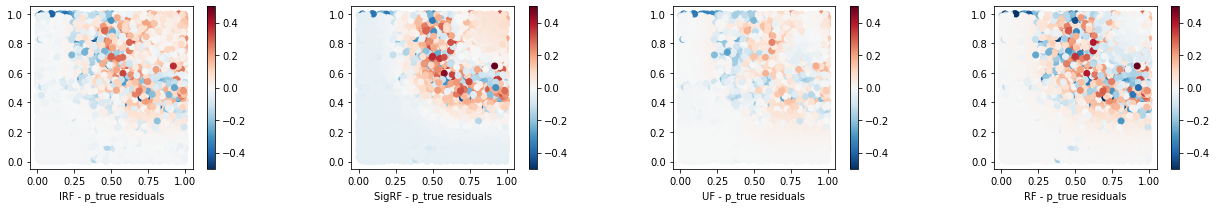

In [92]:
fig, axes = plt.subplots(1, 4, figsize=(18, 3))
for i, ax in enumerate(axes):
    pts = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_probs_true - clf_y_probs_hat[i], cmap='RdBu_r', vmin=-0.5, vmax=0.5)
    ax.set_xlabel(f'{clfs[i][0]} - p_true residuals')
    ax.set_aspect('equal')
    fig.colorbar(pts, ax=ax)
plt.tight_layout()
plt.show()

In [131]:
d = 8
d_idx = 3
X_test, _, _ = sample_data(10000, d, seed=d+1)

clf_y_probs_hat = [
    results_dict[clf][d_idx] for clf, _ in clfs
]

y_probs_true = results_dict['y_probs_test'][d_idx]

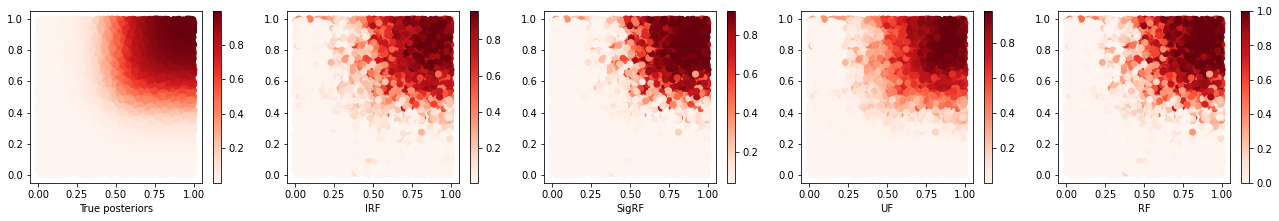

In [89]:
fig, axes = plt.subplots(1, 5, figsize=(18, 3))
for i, ax in enumerate(axes):
    if i == 0:
        pts = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_probs_true, cmap='Reds')
        ax.set_xlabel(f'True posteriors')
    else:
        pts = ax.scatter(X_test[:, 0], X_test[:, 1], c=clf_y_probs_hat[i-1], cmap='Reds')
        ax.set_xlabel(f'{clfs[i-1][0]}')
    ax.set_aspect('equal')
    fig.colorbar(pts, ax=ax)
plt.tight_layout()
plt.show()

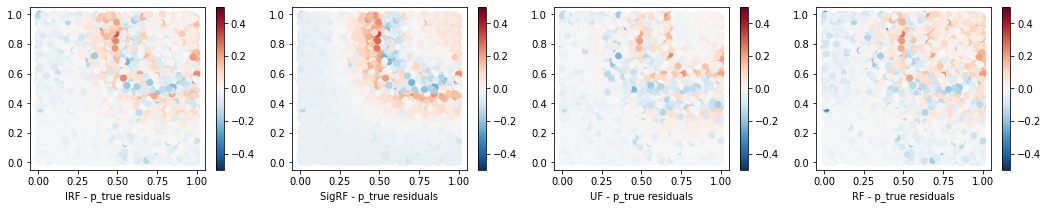

In [132]:
fig, axes = plt.subplots(1, 4, figsize=(18, 3))
for i, ax in enumerate(axes):
    pts = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_probs_true - clf_y_probs_hat[i], cmap='RdBu_r', vmin=-0.5, vmax=0.5)
    ax.set_xlabel(f'{clfs[i][0]} - p_true residuals')

    fig.colorbar(pts, ax=ax)
plt.show()

In [127]:
d = 100
d_idx = 9
X_test, _, _ = sample_data(10000, d, seed=d+1)

clf_y_probs_hat = [
    results_dict[clf][d_idx] for clf, _ in clfs
]

y_probs_true = results_dict['y_probs_test'][d_idx]

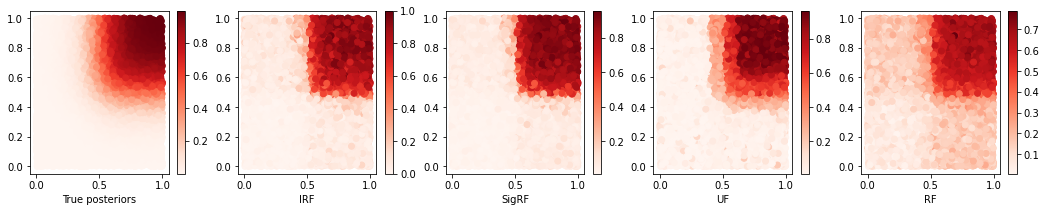

In [128]:
fig, axes = plt.subplots(1, 5, figsize=(18, 3))
for i, ax in enumerate(axes):
    if i == 0:
        pts = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_probs_true, cmap='Reds')
        ax.set_xlabel(f'True posteriors')
    else:
        pts = ax.scatter(X_test[:, 0], X_test[:, 1], c=clf_y_probs_hat[i-1], cmap='Reds')
        ax.set_xlabel(f'{clfs[i-1][0]}')

    fig.colorbar(pts, ax=ax)
plt.show()

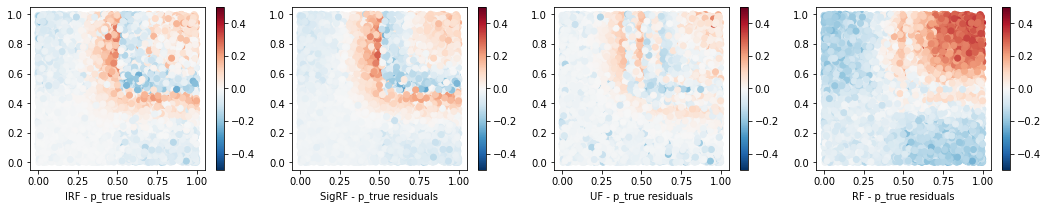

In [130]:
fig, axes = plt.subplots(1, 4, figsize=(18, 3))
for i, ax in enumerate(axes):
    pts = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_probs_true - clf_y_probs_hat[i], cmap='RdBu_r', vmin=-0.5, vmax=0.5)
    ax.set_xlabel(f'{clfs[i][0]} - p_true residuals')

    fig.colorbar(pts, ax=ax)
plt.show()

## Varying sharpness

In [144]:
alpha_results = defaultdict(list)
d = 8
alphas = [1/10, 1/2, 1, 2, 6, 12, 20]
alpha_results['alphas'] = alphas

for alpha in alphas:
    print(alpha)
    X_train, y_train, y_probs_train = sample_data(5000, d, seed=d, alpha=alpha)
    X_test, y_test, y_probs_test = sample_data(10000, d, seed=d+1, alpha=alpha)
    alpha_results['y_test'].append(y_test)
    alpha_results['y_probs_test'].append(y_probs_test)
    for name, clf in clfs:
        clf.fit(X_train, y_train)
        y_probs_test_hat = clf.predict_proba(X_test)[:, 1] # class 1 probs
        alpha_results[name].append(y_probs_test_hat)

0.1
0.5
1
2
6
12
20


In [162]:
cols = ['alpha'] + [clf for clf, _ in clfs]

data = [alpha_results['alphas']]
for clf, _ in clfs:
    scores = [
        hellinger_explicit(alpha_results['y_probs_test'][i], y_proba_hat)
        for i, y_proba_hat in enumerate(alpha_results[clf])
    ]
    data.append(scores)
    
df_alpha = pd.DataFrame(np.asarray(data).T, columns=cols).set_index('alpha')

In [163]:
df_alpha

IRF     SigRF        UF        RF
alpha                                        
0.1    0.014172  0.006993  0.033485  0.048291
0.5    0.021031  0.016563  0.035151  0.049133
1.0    0.030782  0.029075  0.036828  0.050592
2.0    0.042580  0.042336  0.040710  0.052661
6.0    0.051639  0.057029  0.045662  0.052449
12.0   0.056210  0.073318  0.048796  0.058202
20.0   0.055309  0.085175  0.044292  0.068229

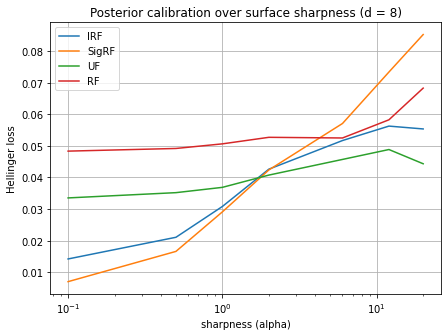

In [164]:
df_alpha.plot(figsize=(7, 5), grid=True)
plt.xlabel('sharpness (alpha)')
plt.ylabel('Hellinger loss')
plt.title('Posterior calibration over surface sharpness (d = 8)')
plt.xticks(np.linspace(2, 20, 7))
plt.xscale('log')
plt.show()

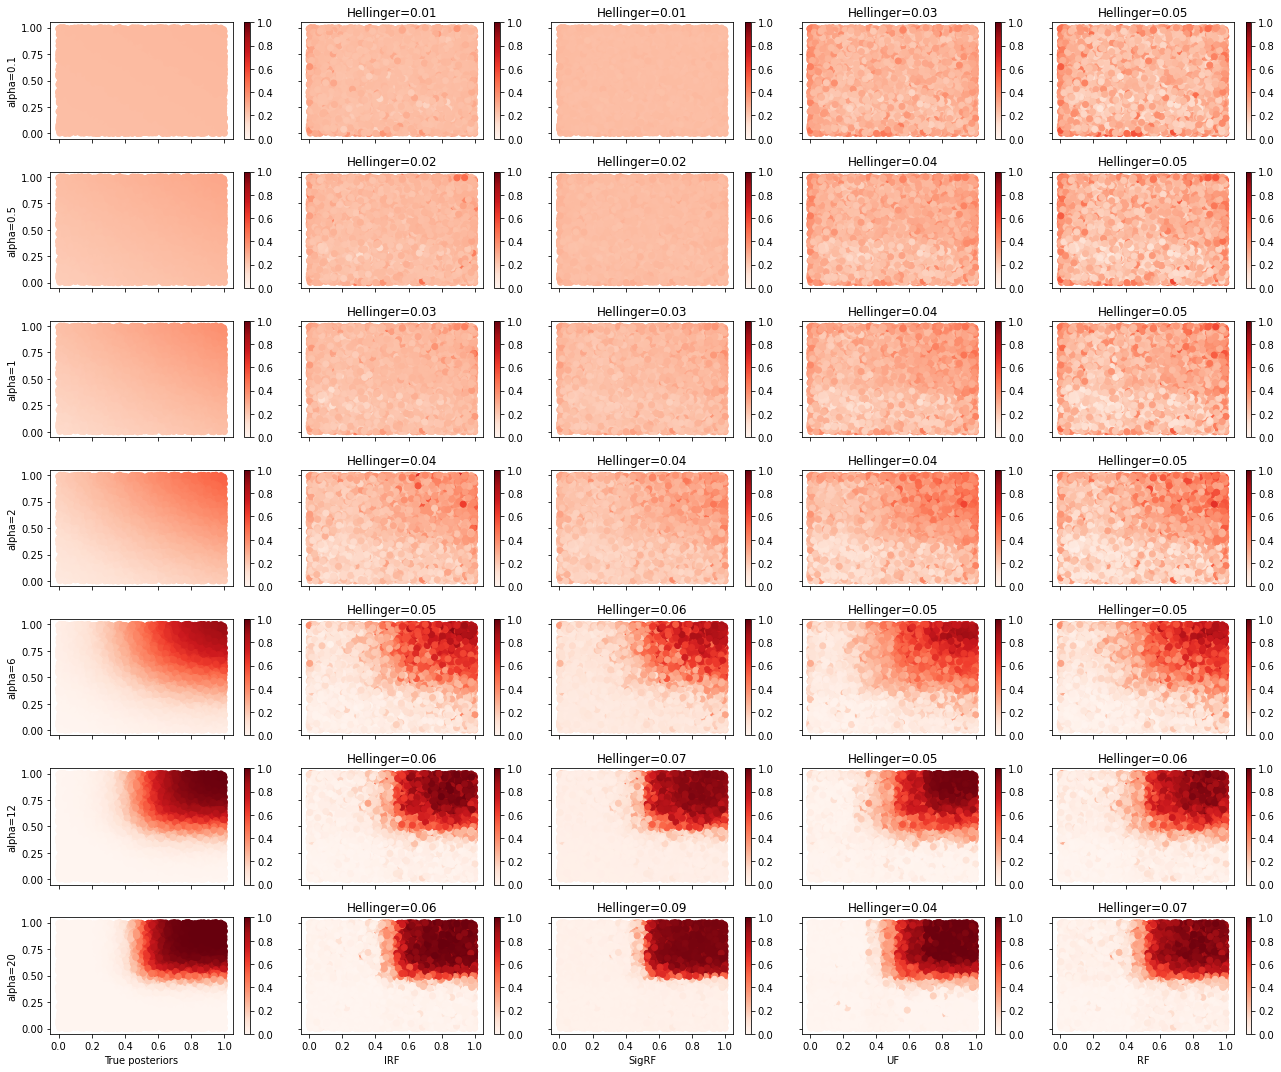

In [168]:
d = 8

X_test, _, _ = sample_data(10000, d, seed=d+1)

clf_y_probs_hat = [
    alpha_results[clf] for clf, _ in clfs
]

y_probs_true = alpha_results['y_probs_test']

fig, axes = plt.subplots(len(alpha_results['alphas']), 5, figsize=(18, 15), sharex=True, sharey=True)
for r in range(axes.shape[0]):
    alpha = alpha_results["alphas"][r]
    for c in range(axes.shape[1]):
        clf_name = clfs[c-1][0]
        ax = axes[r, c]
        if c == 0:
            pts = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_probs_true[r], cmap='Reds', vmin=0, vmax=1)
            if r == axes.shape[0] - 1:
                ax.set_xlabel(f'True posteriors')
        else:
            pts = ax.scatter(X_test[:, 0], X_test[:, 1], c=clf_y_probs_hat[c-1][r], cmap='Reds', vmin=0, vmax=1)
            if r == axes.shape[0] - 1:
                ax.set_xlabel(f'{clf_name}')
            ax.set_title(f'Hellinger={df_alpha.loc[alpha][clf_name]:.2f}')
        fig.colorbar(pts, ax=ax)
    axes[r, 0].set_ylabel(f'alpha={alpha}')
plt.tight_layout()
plt.show()

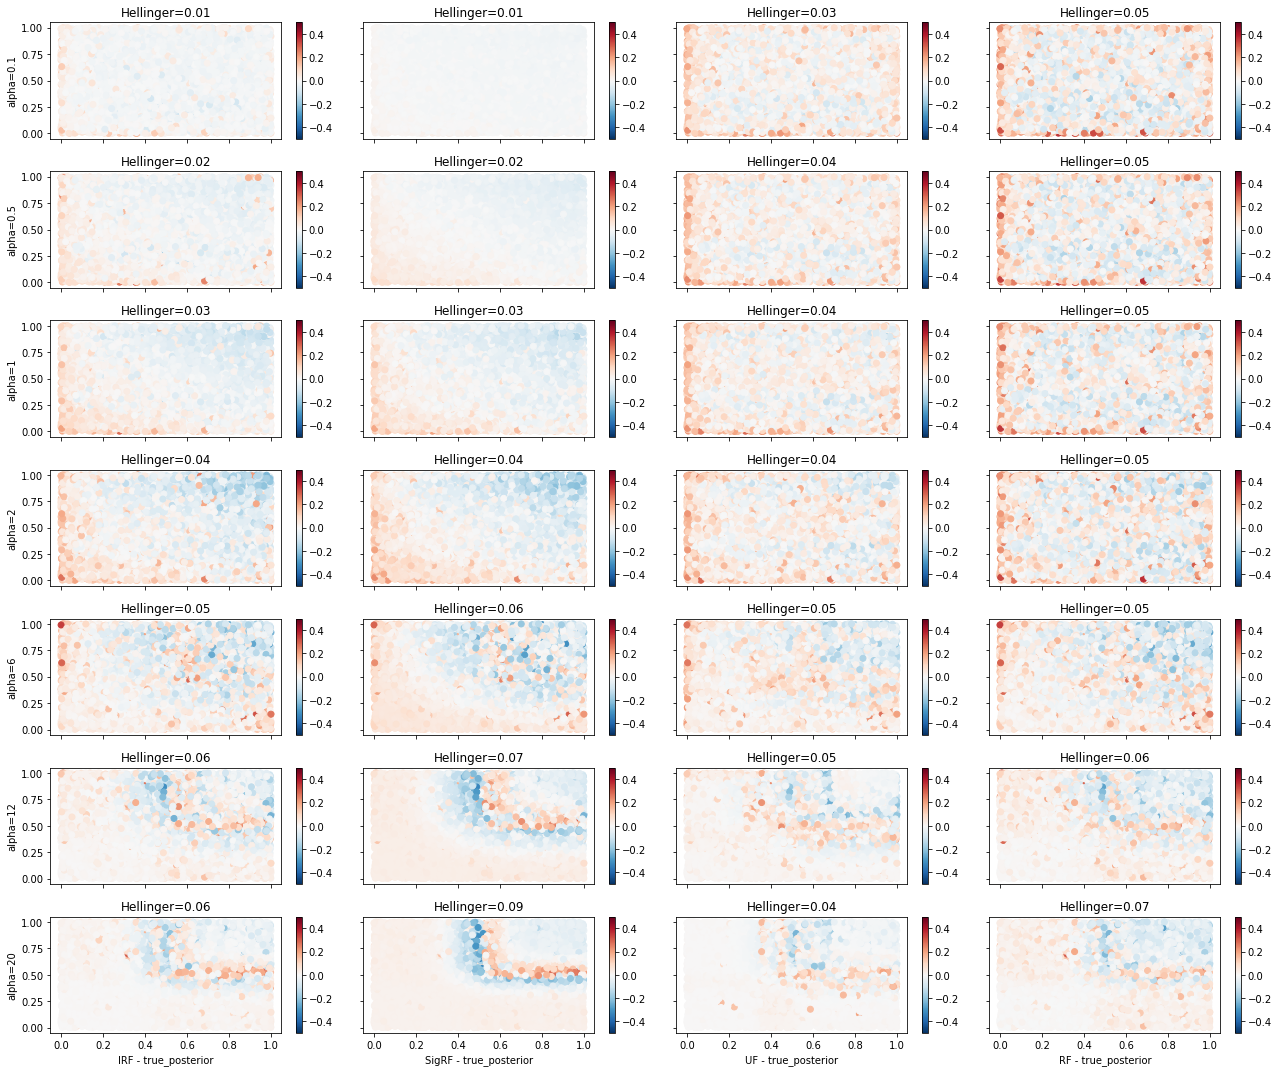

In [172]:
d = 8

X_test, _, _ = sample_data(10000, d, seed=d+1)

clf_y_probs_hat = [
    alpha_results[clf] for clf, _ in clfs
]

y_probs_true = alpha_results['y_probs_test']

fig, axes = plt.subplots(len(alpha_results['alphas']), 4, figsize=(18, 15), sharex=True, sharey=True)
for r in range(axes.shape[0]):
    alpha = alpha_results["alphas"][r]
    row_posteriors = y_probs_true[r]
    for c in range(axes.shape[1]):
        clf_name = clfs[c][0]
        ax = axes[r, c]
        pts = ax.scatter(X_test[:, 0], X_test[:, 1], c=clf_y_probs_hat[c][r] - row_posteriors, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
        if r == axes.shape[0] - 1:
            ax.set_xlabel(f'{clf_name} - true_posterior')
        ax.set_title(f'Hellinger={df_alpha.loc[alpha][clf_name]:.2f}')
        fig.colorbar(pts, ax=ax)
    axes[r, 0].set_ylabel(f'alpha={alpha}')
plt.tight_layout()
plt.show()